# Prefit Model with Student-T 

Replace the normal fit for expression with a StudentT

# Inputs

In [3]:
import warnings
warnings.filterwarnings('ignore')

import rnaseq_lib3 as r

import pandas as pd
import os
import scipy.stats as st
import pymc3 as pm
import numpy as np
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# Read in expression data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

# T-Test Fits
PyMC3's Student T PDF is defined as
$$
f(x|\mu,\lambda,\nu) =
    \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})}
    \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}}
    \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}
$$

and is parameterized by nu, mu, and lambda ($\nu$, $\mu$, $\lambda$)

Scipy's PDF is defined as
$$
f(x, \nu) = 
    \frac{\Gamma((\nu + 1)/2)}{\sqrt{\pi \nu \Gamma(\nu)}}
    (1 + x^2 / \nu) ^{-(\nu + 1)/2}
$$

## SciPy Fit Example

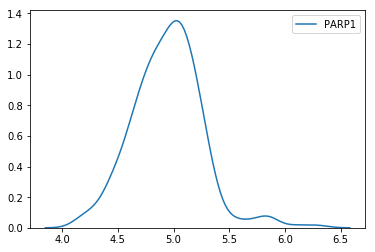

In [5]:
thyroid_parp1 = gtex[gtex.tissue == 'Thyroid']['PARP1']
sns.kdeplot(thyroid_parp1)

In [8]:
df, loc, scale = st.t.fit(thyroid_parp1)
df, loc, scale

(5.949988544805806, 4.939582180518206, 0.25679933113414005)

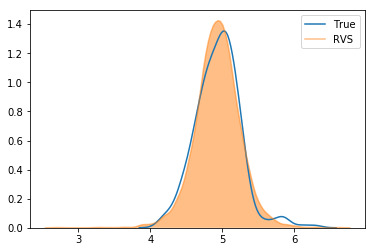

In [11]:
rvs = st.t.rvs(df, loc, scale, 5000)
sns.kdeplot(thyroid_parp1, label='True')
sns.kdeplot(rvs, label='RVS', shade=True, alpha=0.5)

# Model Definition

This currently fits expression for a tissue/gene to a Normal distribution

In [20]:
def run_model(sample, df, training_genes, group, **kwargs):
    """
    Run Bayesian model using prefit Y's for each Gene and Dataset distribution

    Args:
        sample: N-of-1 sample to run
        df: Background dataframe to use in comparison
        training_genes: Genes to use during training
        group: Column to use to distinguish different groups
        **kwargs:

    Returns:
        Model and Trace from PyMC3
    """
    classes = sorted(df[group].unique())
    df = df[[group] + training_genes]
    
    # JORDAN: THIS IS THE NORMAL FIT STEP
    ys = {}
    for gene in training_genes:
        for i, dataset in enumerate(classes):
#             cat_mu, cat_sd = st.norm.fit(df[df[group] == dataset][gene])
#             # Standard deviation can't be initialized to 0, so set to 0.1
#             cat_sd = 0.1 if cat_sd == 0 else cat_sd
#             ys[f'{gene}={dataset}'] = (cat_mu, cat_sd)
            
            # JOHN: these are the the "intuitive" versions of the prior parameters that need to be set
            prior_mean = 0.0
            prior_std_dev = 1.0
            pseudocounts = 1.0
            
            # convert to prior params of normal-inverse gamma
            kappa_0 = pseudocounts
            mu_0 = prior_mean
            alpha_0 = 0.5 * pseudocounts
            beta_0 = 0.5 / prior_std_dev**2
            
            # collect summary statistics for data
            observations = np.array(df[df[group] == dataset][gene])
            n = len(observations)
            obs_sum = np.sum(observations)
            obs_mean = obs_sum / n
            obs_ssd = np.sum(np.square(observations - obs_mean))
            
            # compute the posterior params
            kappa_n = kappa_0 + n
            mu_n = (kappa_0 * mu_0 + obs_sum) / (kappa_0 + n)
            alpha_n = alpha_0 + 0.5 * n
            beta_n = beta_0 + 0.5 * (obs_ssd + kappa_0 * n * (obs_mean - mu_0)**2 / (kappa_0 + n))
            
            # from https://www.seas.harvard.edu/courses/cs281/papers/murphy-2007.pdf, equation (110)
            # convert to the params of a PyMC student-t (i.e. integrate out the prior)
            mu = mu_n
            nu = 2.0 * alpha_n
            lambd = alpha_n * kappa_n / (beta_n * (kappa_n + 1.0))
            
            ys[f'{gene}={dataset}'] = (mu, nu, lambd)

    print('Building model')
    with pm.Model() as model:
        # Linear model priors
        a = pm.Normal('a', mu=0, sd=1)
        b = [1] if len(classes) == 1 else pm.Dirichlet('b', a=np.ones(len(classes)))
        # Model error
        eps = pm.InverseGamma('eps', 2.1, 1)

        # TODO: Try tt.stack to declare mu more intelligently via b * y
        # Linear model declaration
        for gene in tqdm(training_genes):
            mu = a
            for i, dataset in enumerate(classes):
                name = f'{gene}={dataset}'

                # JORDAN: This is where PyMC3 RV is initalized with the fits
                # y = pm.Normal(name, *ys[name])
                m, nu, lambd = ys[name]
                y = pm.StudentT(name, nu = nu, mu = m, lam = lambd)
                mu += b[i] * y

            # Embed mu in laplacian distribution
            pm.Laplace(gene, mu=mu, b=eps, observed=sample[gene])
        # Sample
        trace = pm.sample(**kwargs)
    return model, trace

## Example Run

Select Thyroid Carcinoma sample

In [14]:
sample_id = 'TCGA-DJ-A2PX-01'
sample = tumor.loc[sample_id]

Select background training set (just use 2-3 for now to keep it fast)

In [17]:
ranks = r.outlier.pca_distances(sample, gtex, genes, 'tissue')
ranks.head(3)

,Group,MedianDistance
0,Thyroid,106.173830
1,Minor,109.477750
2,Kidney,112.353126


In [18]:
training_group = gtex[gtex.tissue.isin(ranks.head(3).Group)]

Select training genes

In [19]:
training_genes = r.outlier.select_k_best_genes(training_group, genes, n=40)
training_genes = list(set(training_genes + drug_genes))

Run model - for normal distribution fits this takes about 30-40m

In [21]:
m, t = run_model(sample, training_group, training_genes, group='tissue')

Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PDGFRB=Thyroid, PDGFRB=Minor, PDGFRB=Kidney, TSC2=Thyroid, TSC2=Minor, TSC2=Kidney, STAT1=Thyroid, STAT1=Minor, STAT1=Kidney, DEFB1=Thyroid, DEFB1=Minor, DEFB1=Kidney, ROS1=Thyroid, ROS1=Minor, ROS1=Kidney, TG=Thyroid, TG=Minor, TG=Kidney, BTK=Thyroid, BTK=Minor, BTK=Kidney, IYD=Thyroid, IYD=Minor, IYD=Kidney, NR1H4=Thyroid, NR1H4=Minor, NR1H4=Kidney, FLT1=Thyroid, FLT1=Minor, FLT1=Kidney, FGFR4=Thyroid, FGFR4=Minor, FGFR4=Kidney, HSP90AB3P=Thyroid, HSP90AB3P=Minor, HSP90AB3P=Kidney, NTRK2=Thyroid, NTRK2=Minor, NTRK2=Kidney, KIT=Thyroid, KIT=Minor, KIT=Kidney, RP11-445F12.1=Thyroid, RP11-445F12.1=Minor, RP11-445F12.1=Kidney, COL23A1=Thyroid, COL23A1=Minor, COL23A1=Kidney, SMIM6=Thyroid, SMIM6=Minor, SMIM6=Kidney, CYP2J2=Thyroid, CYP2J2=Minor, CYP2J2=Kidney, MTOR=Thyroid, MTOR=Minor, MTOR=Kidney, PIK3C2A=Thyroid, PIK3C2A=Minor, PIK3C2A=Kidney, NKX2-1-AS1=Thyroid, NKX2-1-AS1=Minor, NKX2-1-AS1=Kidney, PARP1=Thyroid, PARP1=Minor, PARP1=Kidn

# Diagnostics

## Traceplot

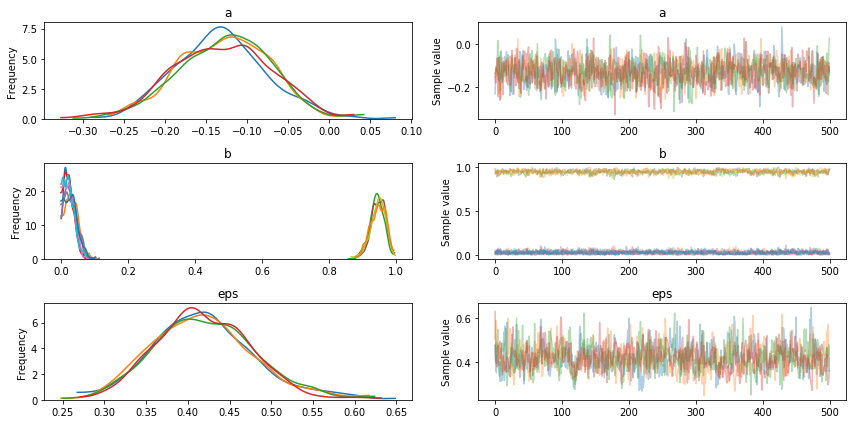

In [22]:
pm.traceplot(t, varnames=['a', 'b', 'eps']);

## Weights

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

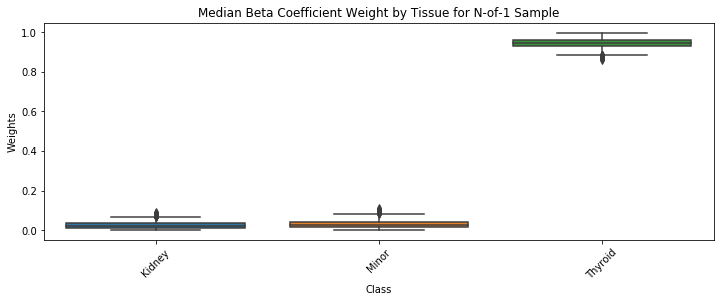

In [23]:
r.outlier.plot_weights(training_group.tissue.unique(), t)
plt.xticks(rotation=45)

## Pvalues

In [24]:
ppc = r.outlier.ppc(t, drug_genes)
ppp = r.outlier.posterior_predictive_pvals(sample, ppc)

In [25]:
ppp

MET          0.01372
CCND2        0.04293
ALK          0.05566
STAT1        0.05730
CCND1        0.06619
PIK3CG       0.12089
MDM2         0.12664
AURKB        0.17639
NTRK2        0.21630
PIK3R2       0.22322
PIK3CB       0.23045
PIK3R4       0.23619
NRAS         0.25452
FLT3         0.25770
CSF1R        0.27410
PIK3R6       0.28077
ROS1         0.28088
BTK          0.28431
AURKA        0.30753
MS4A1        0.30887
PARP1        0.31398
CDK4         0.31765
SMO          0.32274
FGFR2        0.35114
CCND3        0.35994
NTRK3        0.36032
JAK1         0.37457
HSP90AB1     0.37654
ERBB2        0.38654
PIK3R3       0.38706
              ...   
BCL2         0.61083
IL6          0.61519
STAT5B       0.61875
HSP90AB3P    0.62268
CCNE1        0.62356
KRAS         0.63604
ARAF         0.64705
RPTOR        0.64886
TEK          0.64912
PIK3C2A      0.66189
STAT3        0.67589
NTRK1        0.67754
BRAF         0.67889
CDK2         0.70083
DEPTOR       0.70489
PTCH1        0.72173
GLI1         